# **Trend analysis for SPEAR historical**

In [1]:
import os
from math import nan
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from scipy.stats import linregress

In [2]:
dir1 = "/work/Jiale.Lou/shared_data/SPEAR/MED/US/"
dir2 = "/work/Darri.Stuber/spear_with_forcings_land_data"

###  Import Data                                    

In [96]:
low_rh_land = xr.open_dataset(dir2 +f'/low_rh_land.nc')
low_t_raw = xr.open_dataset(dir2 +f'/low_t_land.nc')

med_rh_land = xr.open_dataset(dir2 +f'/med_rh_land.nc')
med_t_land = xr.open_dataset(dir2 +f'/med_t_land.nc')

high_rh_land = xr.open_dataset(dir2 +f'/high_rh_land.nc')
high_t_land = xr.open_dataset(dir2 +f'/high_t_land.nc')

In [98]:
low_rh_land

<xarray.Dataset> Size: 17GB
Dimensions:  (ens: 30, time: 3000, lat: 168, lon: 288)
Coordinates:
  * time     (time) object 24kB 1851-01-16 12:00:00 ... 2100-12-16 12:00:00
  * ens      (ens) int64 240B 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
  * lat      (lat) float64 1kB -77.5 -76.5 -75.5 -74.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
Data variables:
    rh_ref   (ens, time, lat, lon) float32 17GB ...

In [99]:
#get US data (only need to perform calculations over US)
low_rh_us =  low_rh_land.sel(lat=slice(24,50), lon=slice(234, 296))
low_t_us =  low_t_raw.sel(lat=slice(24,50), lon=slice(234, 296))
low_t_us_c =  low_t_raw.sel(lat=slice(24,50), lon=slice(234, 296))
low_t_us_c['t_ref'] =  low_t_us_c['t_ref'] - 273.15

med_rh_us =  med_rh_land.sel(lat=slice(24,50), lon=slice(234, 296))
med_t_us =  med_t_land.sel(lat=slice(24,50), lon=slice(234, 296))
med_t_us_c =  med_t_land.sel(lat=slice(24,50), lon=slice(234, 296))
med_t_us_c['t_ref'] =  med_t_us_c['t_ref'] - 273.15


high_rh_us =  high_rh_land.sel(lat=slice(50, 24), lon=slice(234, 296))
high_t_us =  high_t_land.sel(lat=slice(50, 24), lon=slice(234, 296))
high_t_us_c =  high_t_land.sel(lat=slice(50, 24), lon=slice(234, 296))
high_t_us_c['t_ref'] =  high_t_us_c['t_ref'] - 273.15

### Calculate VP metrics

In [101]:
# calculating DP

a1 = 243.04
a2 = 17.625


def calc_dp(rh_data, t_data):
    rh_data, t_data = rh_data.rename({"rh_ref": "dp"}), t_data.rename(
        {"t_ref": "dp"}
    )  # so final dps has a dp data variable - otherwise extract values
    td_num = a1 * (np.log(rh_data / 100) + ((a2 * t_data) / (a1 + t_data)))
    td_dem = a2 - (np.log(rh_data / 100) + ((a2 * t_data) / (a1 + t_data)))
    dps = td_num / td_dem
    return dps

#med_dps = calc_dp(med_rh_us, med_t_us)

med_dps = calc_dp(med_rh_us, med_t_us_c)
low_dps = calc_dp(low_rh_us, low_t_us_c)
high_dps = calc_dp(high_rh_us, high_t_us_c)

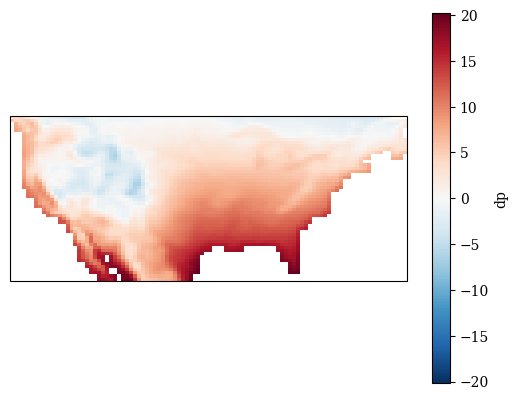

In [104]:
#check
fig = plt.figure()
ax = fig.add_subplot(
    1, 1, 1, projection=ccrs.PlateCarree()
)  # always use projection , zorder = priority (high zorder appears on top_
med_dps.dp.mean(dim = ['ens',"time"]).plot()

In [16]:
# calculate vp, svp, and vpd
c1 = 6.112  # hPa
c2 = 17.67
c3 = 243.5  # °C


def calc_vp_stuff(dp_data, t_data):
    dew_point_temp = dp_data 
    air_temp = t_data 

    es_values = c1 * np.exp((c2 * air_temp) / (c3 + air_temp))
    es = es_values.rename({"t_ref": "es"})

    ea_values = c1 * np.exp((c2 * dew_point_temp) / (c3 + dew_point_temp))
    ea = ea_values.rename({"dp": "ea"})

    vpd_es = es_values.rename({"t_ref": "vpd"})
    vpd_ea = ea_values.rename({"dp": "vpd"})
    vpd = vpd_es - vpd_ea
    return ea, es, vpd


med_ea, med_es, med_vpd = calc_vp_stuff(med_dps, med_t_us_c)
low_ea, low_es, low_vpd = calc_vp_stuff(low_dps, low_t_us_c)
high_ea, high_es, high_vpd = calc_vp_stuff(high_dps, high_t_us_c)
#med_ea.to_netcdf('med_ea.nc')

In [107]:
med_ea

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 2160, ens: 30, lat: 52, lon: 100)
Coordinates:
  * time     (time) object 17kB 1921-01-16 12:00:00 ... 2100-12-16 12:00:00
  * ens      (ens) int64 240B 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
  * lat      (lat) float64 416B 24.25 24.75 25.25 25.75 ... 48.75 49.25 49.75
  * lon      (lon) float64 800B 234.1 234.7 235.3 235.9 ... 294.7 295.3 295.9
Data variables:
    ea       (ens, time, lat, lon) float32 1GB nan nan nan nan ... nan nan nan

### Trend calculations

In [18]:
#function to get annual southwest VP/SVP averaged spatially
def get_EA_ES(ea, es):
    ea_sw = ea.sel(lat=slice(31, 42), lon=slice(232, 258))
    es_sw = es.sel(lat=slice(31, 42), lon=slice(232, 258))

    ea_group_year_sw = ea_sw.groupby("time.year").mean(dim="time")
    EA_SW = ea_group_year_sw.groupby("year").mean(dim=["lat", "lon"])

    es_group_year_sw = es_sw.groupby("time.year").mean(dim="time")
    ES_SW = es_group_year_sw.groupby("year").mean(dim=["lat", "lon"])
    return EA_SW, ES_SW


med_EA_SW, med_ES_SW = get_EA_ES(med_ea, med_es)
low_EA_SW, low_ES_SW = get_EA_ES(low_ea, low_es)
high_EA_SW, high_ES_SW = get_EA_ES(high_ea, high_es)

In [19]:
#get trend over specific timeframe
def new_slope(dataset, value, minyear, maxyear):
    slim_data = dataset.sel(year=slice(minyear, maxyear))
    vals = slim_data[value].values
    yrs = slim_data["year"]
    slope, intercept, r_value, p_value, std_err = linregress(yrs, vals)
    return slope

In [25]:
#generate 30 year moving trend - only using medium but could use others
def get_30trend(EA_SW, ES_SW, maxens):
    trend_by_30 = pd.DataFrame(columns=["year", "ens", "vp_trend", "svp_trend"])
    for i in range(1, maxens):
        curr_year = 2020
        while curr_year >= 1971:
            # print(curr_year)
            vp_trend = new_slope(EA_SW.sel(ens=i), "ea", (curr_year - 30), curr_year)
            s_trend = new_slope(ES_SW.sel(ens=i), "es", (curr_year - 30), curr_year)
            trend_by_30.loc[len(trend_by_30)] = [curr_year, i, vp_trend, s_trend]
            curr_year -= 1
    return trend_by_30


med_trend30 = get_30trend(med_EA_SW, med_ES_SW, 31)
low_trend30 = get_30trend(low_EA_SW, low_ES_SW, 31)
high_trend30 = get_30trend(high_EA_SW, high_ES_SW, 11)

In [23]:
#get ens average 30 year moving trend values
def get_avg_30trend(EA_SW, ES_SW, curr_year, min_year):
    trend_by_30 = pd.DataFrame(columns=["year", "vp_trend", "svp_trend"])
    #curr_year = 2020
    while curr_year >= min_year: #1951:
        vp_trend = new_slope(EA_SW, "ea", (curr_year - 30), curr_year)
        s_trend = new_slope(ES_SW, "es", (curr_year - 30), curr_year)
        trend_by_30.loc[len(trend_by_30)] = [curr_year, vp_trend, s_trend]
        curr_year -= 1
    return trend_by_30


avg_l30 = get_avg_30trend(low_EA_SW.mean('ens'), low_ES_SW.mean('ens'), 2020, 1951)
avg_m30 = get_avg_30trend(med_EA_SW.mean('ens'), med_ES_SW.mean('ens'), 2020, 1951)
avg_h30 = get_avg_30trend(high_EA_SW.mean('ens'), high_ES_SW.mean('ens'), 2020, 1951)

In [26]:
#store the min, 25th quartile, average, 75th, and max for all ensembles
def get_qs(trend_df, avg_trend_df):#, avg_trend_df):
    year_qs = pd.DataFrame(
        columns=["year", "ea_minimum", "ea_q1","ea_mean","ea_q3","ea_maximum","es_minimum","es_q1","es_mean", "es_q3","es_maximum",])
    for year in range(1971, 2021):
        ea_year = trend_df.loc[(trend_df["year"] == year), ["vp_trend", "svp_trend"]]
        min_ea, min_es = ea_year.min()
        q1_ea, q1_es = ea_year.quantile(0.25)
        mean_ea, mean_es = avg_trend_df.loc[avg_trend_df["year"] == year, ["vp_trend", "svp_trend"]].values[0]
        #mean_ea, mean_es = ea_year.mean()
        q3_ea, q3_es = ea_year.quantile(0.75)
        max_ea, max_es = ea_year.max()

        year_qs.loc[len(year_qs)] = [year, min_ea, q1_ea, mean_ea, q3_ea, max_ea, min_es, q1_es, mean_es, q3_es, max_es,]
    return year_qs


med_qs = get_qs(med_trend30, avg_m30)
low_qs = get_qs(low_trend30, avg_l30)
high_qs = get_qs(high_trend30, avg_h30)

### 30 Year Moving Trend Visualizations

In [27]:
era5_30trends = pd.read_csv("/work/Darri.Stuber/era5_30trends.csv")

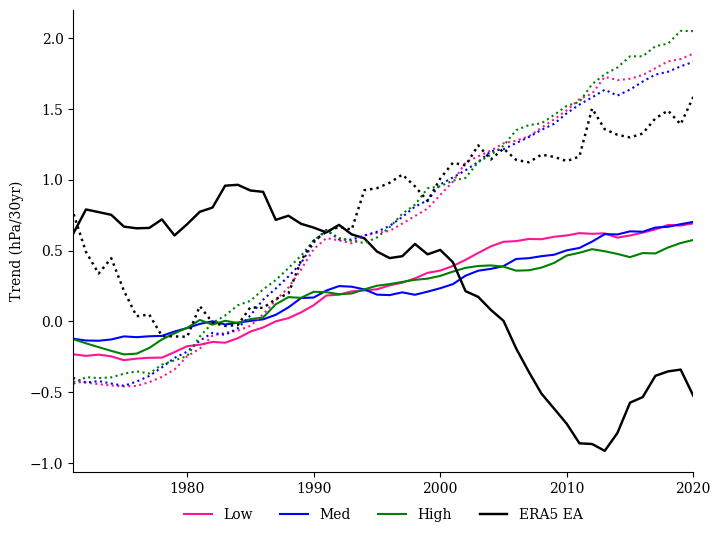

In [44]:
plt.figure(figsize=(8, 6))
plt.rcParams["font.family"] = "serif"

plt.plot(low_qs["year"], low_qs["ea_mean"] * 30, color="deeppink", label=f"Low")
plt.plot(med_qs["year"], med_qs["ea_mean"] * 30, color="blue", label=f"Med")
plt.plot(high_qs["year"], high_qs["ea_mean"] * 30, color="green", label=f"High")

plt.plot( era5_30trends["year"], era5_30trends["vp_trend"] * 30, label="ERA5 EA", color="black", linewidth=1.75,)

plt.plot(low_qs["year"],  low_qs["es_mean"] * 30, color="deeppink",  linestyle=":",)
plt.plot( med_qs["year"], med_qs["es_mean"] * 30, color="blue",  linestyle=":",)
plt.plot(high_qs["year"],  high_qs["es_mean"] * 30, color="green",  linestyle=":",)

plt.plot( era5_30trends["year"], era5_30trends["svp_trend"] * 30, color="black", linestyle=":",  linewidth=1.75,)

plt.xlim(1971, 2020)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow = False, frameon = False, ncol = 4,)
#plt.savefig(f'resolution_ts.png', dpi=1200, bbox_inches='tight', transparent = True)
plt.ylabel("Trend (hPa/30yr)")
plt.show()


In [ ]:
def calculate_rmse(true_values, predicted_values):
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

def calculate_mae(true_values, predicted_values):
    return np.mean(np.abs(true_values - predicted_values))

def calculate_errors(resolution, era5_ea, era5_es):
    ea_rmse = calculate_rmse(era5_ea, resolution["ea_mean"] * 30)
    es_rmse = calculate_rmse(era5_es, resolution["es_mean"] * 30)

    ea_mae = calculate_mae(era5_ea, resolution["ea_mean"] * 30)
    es_mae = calculate_mae(era5_es, resolution["es_mean"] * 30)

    return ea_rmse, es_rmse, ea_mae, es_mae

era5_ea = era5_30trends["vp_trend"]*30
era5_es = era5_30trends["svp_trend"]*30

low_ea_rmse, low_es_rmse, low_ea_mae, low_es_mae = calculate_errors(low_qs, era5_ea, era5_es)
med_ea_rmse, med_es_rmse, med_ea_mae, med_es_mae = calculate_errors(med_qs, era5_ea, era5_es)
high_ea_rmse, high_es_rmse, high_ea_mae, high_es_mae = calculate_errors(high_qs, era5_ea, era5_es)

'''print("RMSE:")
print(f"Low res EA RMSE: {low_ea_rmse:.3f}, ES RMSE: {low_es_rmse:.3f}")
print(f"Medium res EA RMSE: {med_ea_rmse:.3f},  ES RMSE: {med_es_rmse:.3f}")
print(f"High res EA RMSE: {high_ea_rmse:.3f},  ES RMSE: {high_es_rmse:.3f}")

print("\nMAE:")
print(f"Low res EA MAE: {low_ea_mae:.3f}, ES MAE: {low_es_mae:.3f}")
print(f"Medium res EA MAE: {med_ea_mae:.3f},  ES MAE: {med_es_mae:.3f}")
print(f"High res EA MAE: {high_ea_mae:.3f},  ES MAE: {high_es_mae:.3f}")
'''
# low RMSE = res with the smallest large errors comp to ERA5
# low MAE = res with the smallest average error comp to ERA5

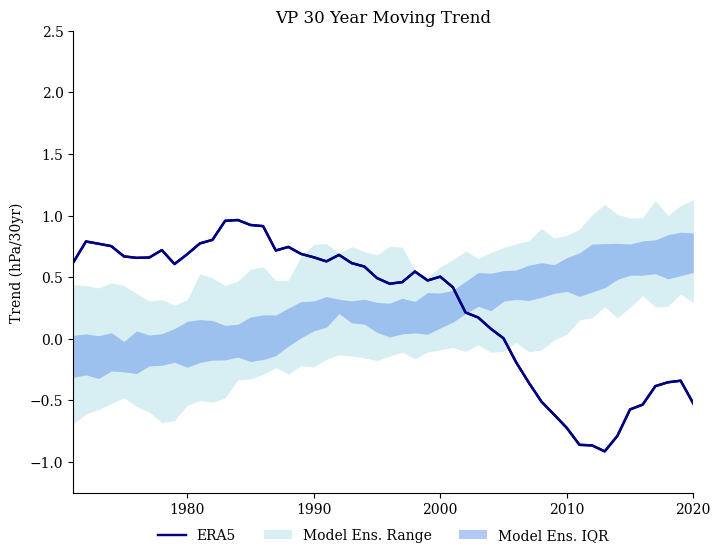

In [43]:
plt.figure(figsize=(8, 6))
plt.rcParams["font.family"] = "serif"
plt.plot( era5_30trends["year"], era5_30trends["vp_trend"] * 30, color="navy", label="ERA5", linewidth=1.75,)

plt.fill_between(med_qs["year"],med_qs["ea_minimum"] * 30, med_qs["ea_maximum"] * 30, alpha=0.5, linewidth=0, color="powderblue",label = 'Model Ens. Range')
plt.fill_between(med_qs["year"], med_qs["ea_q1"] * 30, med_qs["ea_q3"] * 30, alpha=0.5, linewidth=0, color="cornflowerblue",label = 'Model Ens. IQR')
plt.plot( era5_30trends["year"], era5_30trends["vp_trend"] * 30, color="navy",  linewidth=1.75,)
#plt.axhline(y = 0, color = 'black', linestyle = ':') 

plt.xlim(1971, 2020)
plt.ylim(-1.25, 2.5)
#plt.ylim(-2.5, 2.5)

plt.title('VP 30 Year Moving Trend')
plt.ylabel("Trend (hPa/30yr)")
#plt.legend()
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow = False, frameon = False, ncol = 3)
plt.savefig(f'zipfiles/vp_ts_plot.png', dpi=1200, bbox_inches='tight', transparent = True)
plt.show()

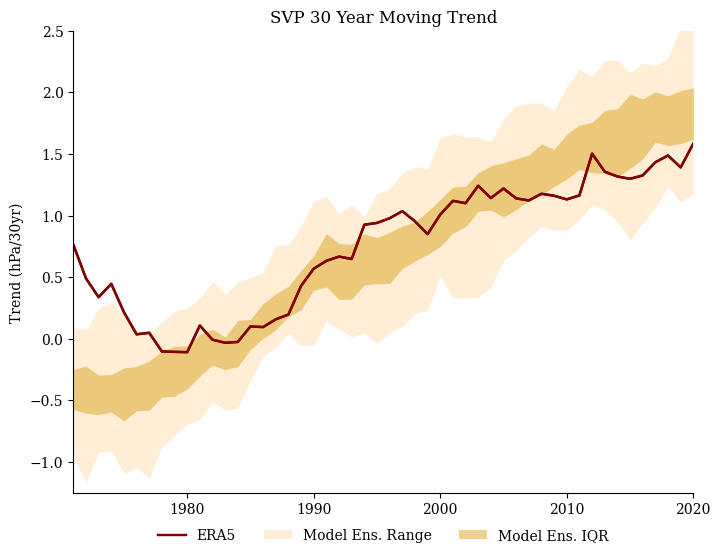

In [32]:
plt.figure(figsize=(8, 6))
plt.rcParams["font.family"] = "serif"
plt.plot( era5_30trends["year"], era5_30trends["svp_trend"] * 30, color="maroon", label="ERA5", linewidth=1.75,)

plt.fill_between(med_qs["year"],med_qs["es_minimum"] * 30, med_qs["es_maximum"] * 30, alpha=0.5, linewidth=0, color="navajowhite",label = 'Model Ens. Range')
plt.fill_between(med_qs["year"], med_qs["es_q1"] * 30, med_qs["es_q3"] * 30, alpha=0.5, linewidth=0, color="goldenrod",label = 'Model Ens. IQR')
plt.plot( era5_30trends["year"], era5_30trends["svp_trend"] * 30, color="maroon",  linewidth=1.75,)

plt.xlim(1971, 2020)
plt.ylim(-1.25, 2.5)
plt.title('SVP 30 Year Moving Trend')
plt.ylabel("Trend (hPa/30yr)")
#plt.legend()
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow = False, frameon = False, ncol = 3)
#plt.savefig(f'zipfiles/svp_ts_plot.png', dpi=1200, bbox_inches='tight', transparent =True)
plt.show()

<Figure size 800x600 with 0 Axes>

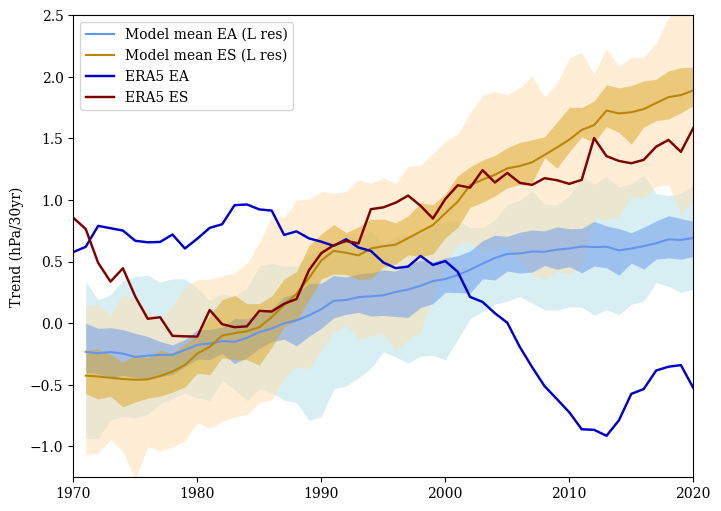

<Figure size 800x600 with 0 Axes>

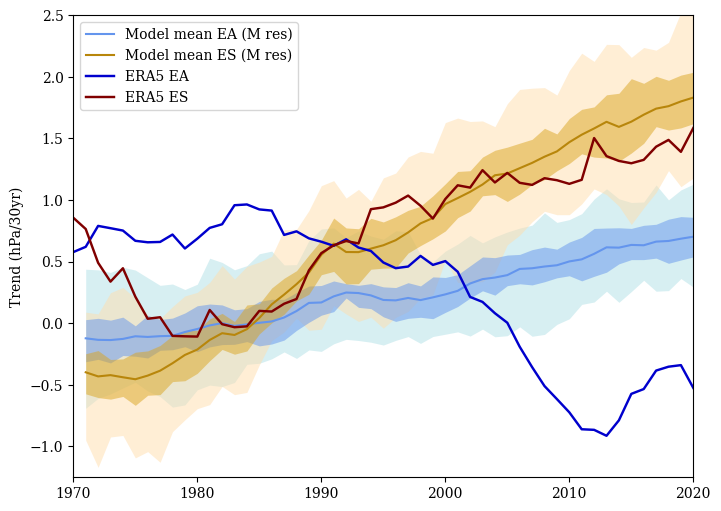

<Figure size 800x600 with 0 Axes>

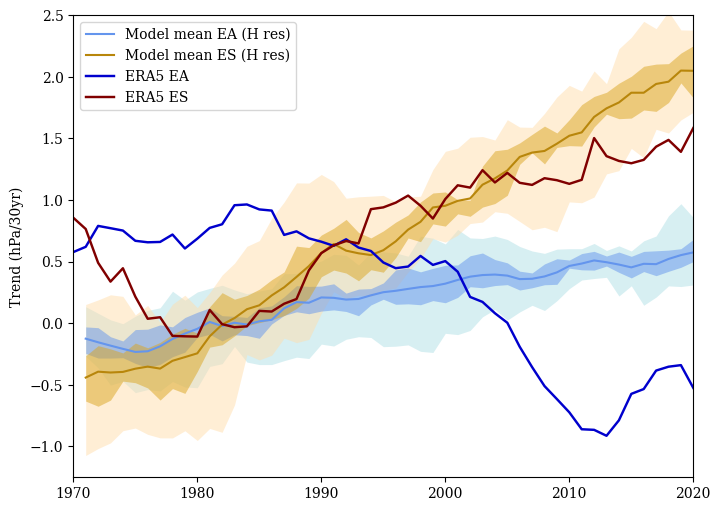

In [33]:
def make_single_line_plot(year_qs, res):
    plt.figure(figsize=(8, 6))
    plt.figure(figsize=(8, 6))
    plt.fill_between(year_qs["year"],year_qs["ea_minimum"] * 30, year_qs["ea_maximum"] * 30, alpha=0.5, linewidth=0, color="powderblue",)
    plt.fill_between( year_qs["year"], year_qs["es_minimum"] * 30, year_qs["es_maximum"] * 30, alpha=0.5, linewidth=0, color="navajowhite",)
    plt.fill_between( year_qs["year"], year_qs["ea_q1"] * 30, year_qs["ea_q3"] * 30, alpha=0.5, linewidth=0, color="cornflowerblue",)
    plt.fill_between( year_qs["year"], year_qs["es_q1"] * 30,  year_qs["es_q3"] * 30,  alpha=0.5, linewidth=0, color="goldenrod",)

    plt.plot(year_qs["year"], year_qs["ea_mean"] * 30, color="cornflowerblue", label=f"Model mean EA {res}",)
    plt.plot( year_qs["year"],  year_qs["es_mean"] * 30, color="darkgoldenrod", label=f"Model mean ES {res}",)

    plt.plot( era5_30trends["year"], era5_30trends["vp_trend"] * 30, label="ERA5 EA", color="mediumblue", linewidth=1.75,)
    plt.plot( era5_30trends["year"], era5_30trends["svp_trend"] * 30, color="maroon", label="ERA5 ES", linewidth=1.75,)

    plt.xlim(1970, 2020)
    plt.ylim(-1.25, 2.5)

    plt.legend()
    plt.ylabel("Trend (hPa/30yr)")
    plt.show()


make_single_line_plot(low_qs, "(L res)")
make_single_line_plot(med_qs, "(M res)")
make_single_line_plot(high_qs, "(H res)")